# **Text-classification with NLP-Neural networks** #

The objective of the project is :
1. To classify a review is good or bad
2. To classify a article is good or bad based on headline

# **IMDB reviews dataset** #

It is a labeled dataset where the input is the movie review(in-text) and the output is positive or negative.It is already availble in tensorflow_datasets so no need to download.

**import required packages**

In [44]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


## **Data collection and preprocessing** #

Download dataset from **tensoflow_datasets** <br>

the **imdb** contains the actual data <review,label> and **info** contains the meta data about the dataset.

In [3]:
imdb,info = tfds.load("imdb_reviews",with_info=True, as_supervised = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteIAU110/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteIAU110/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteIAU110/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [10]:
example = imdb['train'].take(1)
for review, label in example:
    print("Review: ", review.numpy().decode('utf-8'))
    print("Label: ", label.numpy())

Review:  This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
Label:  0


### **Train-Test split** ###
The imdb dataset has 50000 records. 25000 for training and 25000 for testing.

In [11]:
train_data ,test_data = imdb['train'],imdb['test']

### **Feature Extraction** ###
extract training and test reviews(sentences) and their repective labels

In [13]:
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

#Loop through the datasets
for s,l in train_data :
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())

for s,l in test_data :
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())

In [15]:
training_sentences[0]

"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

In [16]:
training_labels[0]

0

convert the labels list to np.array

In [25]:
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

### **Tokenize the reviews** ###
The neural networks only take number vector as input, so convert the text into tokens (i.e. Map words with numbers(tokens)). append those tokens and form sequences. set the maximum length to the sequences and add 0's for padding.

In [22]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded_sequences = pad_sequences(sequences,maxlen=max_length,truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded_sequences = pad_sequences(testing_sequences,maxlen=max_length,truncating=trunc_type)

till now we are done with tokenizing the sentences ,padding and truncating. Now let's see , how we can feed these tokenized sequences to a neural networks.

## **Model-implementation** ##
I have tried two models ,one with **Flatten()** layer and another one with **GlobalAvaragePooling()** layer.

**Model architecture** : first our models have **Embedding** Layer as first layer which converts the tokens into embedding vectors(2D matrix). then  the Flatten() or Pooling() layer converts it to 1D array and feeds it to Dense layers. The output layer predicts and gives the probability . Based on the probability we will assign the record to one of the two classes.

### **Model 1** ###

#### **Model creation** ####

In [23]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length = max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

1.The input sequence, where each number represents a word or token, is converted into embedding vectors using the embedding layer. Each word is represented by a dense vector with a dimension equal to embedding_dim.

2.The embedding layer produces a matrix where each row corresponds to the embedding vector of a word in the sequence. This matrix has dimensions (max_length, embedding_dim).

3.The Flatten layer is used to flatten this 2D matrix into a 1D array. The purpose of flattening is to convert the sequence of embedded words into a format that can be processed by dense layers.

4.The flattened array is then passed through a dense layer with 6 neurons and ReLU activation. This layer introduces non-linearity to the model.

5.Finally, the output from the previous dense layer is passed through another dense layer with a single neuron and sigmoid activation, producing the final binary classification output (0 or 1).

tf.keras.Sequential() is a way to define a linear stack of layers in a neural network using TensorFlow's Keras API. It allows you to create a model by adding one layer at a time in a sequential manner. Each layer in the model is connected to the previous one, forming a chain-like structure.

When you create a Sequential model, Keras automatically initializes the model for you. You can simply add layers one after another, and Keras will take care of connecting them appropriately.

#### **model training** #####


In [33]:
# Compile the model
model1.compile(optimizer='adam',  # You can choose other optimizers like 'sgd', 'rmsprop', etc.
              loss='binary_crossentropy',  # Binary cross-entropy for binary classification
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])  # You can add more metrics if needed

# Train the model
epochs = 10  # Specify the number of training epochs
batch_size = 20  # Specify the batch size
history1 = model1.fit(training_padded_sequences, training_labels_final, epochs=epochs, batch_size=batch_size, validation_data=(testing_padded_sequences,testing_labels_final))

Epoch 1/10
1250/1250 [==============================] - 12s 9ms/step - loss: 0.0024 - accuracy: 0.9992 - precision_3: 0.9994 - recall_3: 0.9990 - val_loss: 1.5794 - val_accuracy: 0.7886 - val_precision_3: 0.7831 - val_recall_3: 0.7982
Epoch 2/10
1250/1250 [==============================] - 14s 11ms/step - loss: 0.0018 - accuracy: 0.9992 - precision_3: 0.9994 - recall_3: 0.9990 - val_loss: 1.5956 - val_accuracy: 0.7936 - val_precision_3: 0.7833 - val_recall_3: 0.8116
Epoch 3/10
1250/1250 [==============================] - 9s 7ms/step - loss: 1.0978e-04 - accuracy: 1.0000 - precision_3: 1.0000 - recall_3: 1.0000 - val_loss: 1.5922 - val_accuracy: 0.7935 - val_precision_3: 0.7958 - val_recall_3: 0.7895
Epoch 4/10
1250/1250 [==============================] - 8s 7ms/step - loss: 5.6699e-06 - accuracy: 1.0000 - precision_3: 1.0000 - recall_3: 1.0000 - val_loss: 1.5987 - val_accuracy: 0.7927 - val_precision_3: 0.7975 - val_recall_3: 0.7846
Epoch 5/10
1250/1250 [==============================]

**Training visualization**

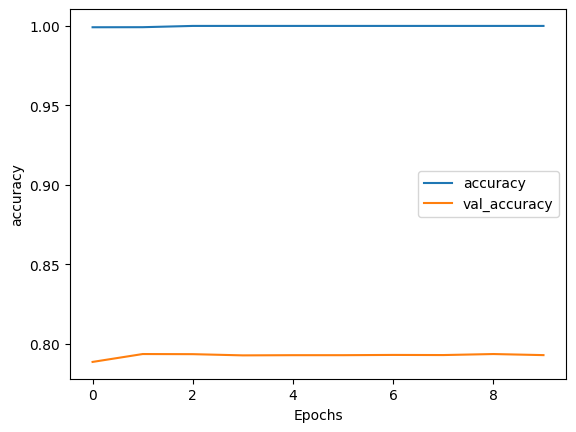

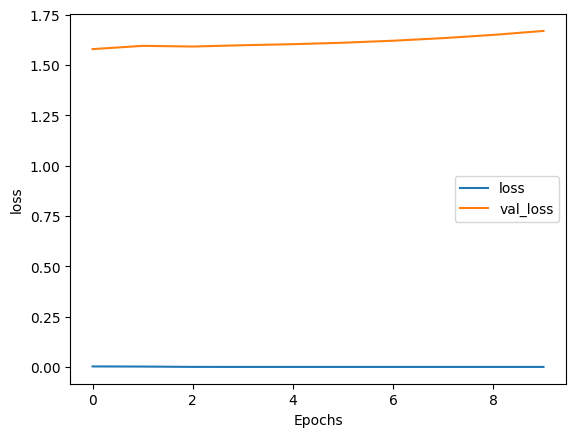

In [34]:
# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and results
plot_graphs(history1, "accuracy")
plot_graphs(history1, "loss")

#### **model testing** ####
It's time for testing. The model predicts the probabilities so records which have probability less than or equal to 0.5 will fall into one class(Negative review) and the rest will fall into another class(Positive review)

In [27]:
# Assuming your model is already trained and you have testing data
predictions = model1.predict(testing_padded_sequences)

# If you have binary classification, you might want to convert the probabilities to class labels (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)
#binary_predictions

782/782 [==============================] - 1s 2ms/step


Here we can compare predictions vs actual values of the labels

In [28]:
print(testing_labels_final)
print(binary_predictions)

[1 1 0 ... 0 1 1]
[[1]
 [1]
 [0]
 ...
 [0]
 [1]
 [1]]


**Evaluation Metrics**

In [30]:
# Accuracy
accuracy = accuracy_score(testing_labels_final, binary_predictions)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(testing_labels_final, binary_predictions)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(testing_labels_final, binary_predictions)
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(testing_labels_final, binary_predictions)
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.8081
Precision: 0.8151
Recall: 0.7970
F1 Score: 0.8059


**Model summary**

In [ ]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense_4 (Dense)             (None, 6)                 11526     
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171533 (670.05 KB)
Trainable params: 171533 (670.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We can observe that the training accuracy is almost **1** but the testing accuracy is **0.8**.There is overfitting.

### **Model 2** ###
Replace the Flatten() layer with Pooling() layer.

####  **Model Creation** ####

We can use globalavaragepooling 1D instead of Flatten

In [31]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

#### Model Training ####

In [35]:
# Compile the model
model2.compile(optimizer='adam',  # You can choose other optimizers like 'sgd', 'rmsprop', etc.
              loss='binary_crossentropy',  # Binary cross-entropy for binary classification
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])  # You can add more metrics if needed

# Train the model
epochs = 10  # Specify the number of training epochs
batch_size = 20  # Specify the batch size
history2 = model2.fit(training_padded_sequences, training_labels_final, epochs=epochs, batch_size=batch_size, validation_data=(testing_padded_sequences,testing_labels_final))

Epoch 1/10
1250/1250 [==============================] - 10s 8ms/step - loss: 0.5273 - accuracy: 0.7600 - precision_4: 0.8151 - recall_4: 0.6727 - val_loss: 0.3996 - val_accuracy: 0.8235 - val_precision_4: 0.8220 - val_recall_4: 0.8258
Epoch 2/10
1250/1250 [==============================] - 14s 11ms/step - loss: 0.3205 - accuracy: 0.8678 - precision_4: 0.8618 - recall_4: 0.8760 - val_loss: 0.3656 - val_accuracy: 0.8401 - val_precision_4: 0.8461 - val_recall_4: 0.8314
Epoch 3/10
1250/1250 [==============================] - 10s 8ms/step - loss: 0.2623 - accuracy: 0.8950 - precision_4: 0.8897 - recall_4: 0.9018 - val_loss: 0.3776 - val_accuracy: 0.8345 - val_precision_4: 0.8505 - val_recall_4: 0.8116
Epoch 4/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.2280 - accuracy: 0.9118 - precision_4: 0.9068 - recall_4: 0.9181 - val_loss: 0.3971 - val_accuracy: 0.8304 - val_precision_4: 0.8366 - val_recall_4: 0.8211
Epoch 5/10
1250/1250 [==============================] - 12s 

**Visualize the training**

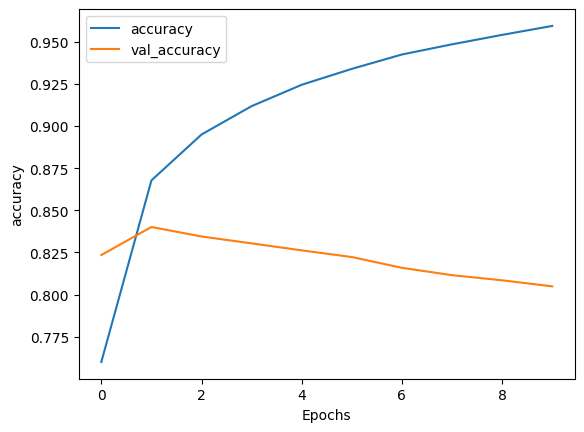

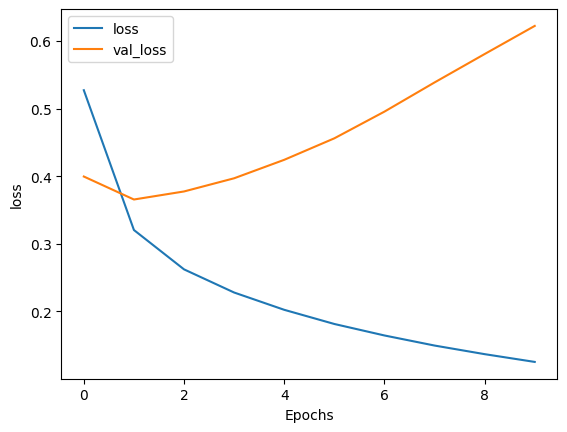

In [36]:
# Plot the accuracy and results
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")

#### **Model Testing** ####
It's time for testing...

In [37]:
# Assuming your model is already trained and you have testing data
predictions = model2.predict(testing_padded_sequences)

# If you have binary classification, you might want to convert the probabilities to class labels (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)
#binary_predictions

782/782 [==============================] - 2s 2ms/step


**Evaluation Metrics**

In [38]:
# Accuracy
accuracy = accuracy_score(testing_labels_final, binary_predictions)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(testing_labels_final, binary_predictions)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(testing_labels_final, binary_predictions)
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(testing_labels_final, binary_predictions)
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.8049
Precision: 0.8040
Recall: 0.8064
F1 Score: 0.8052


Still overfitting.....

**Model 2 summary**

In [39]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_6 (Dense)             (None, 6)                 102       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 160109 (625.43 KB)
Trainable params: 160109 (625.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Embeddings ###
After passing the input sequences to the Embedding layer we will get word embeddings. Let's plot the embedding vectors in 3D space using Embedding Projector.

In [40]:
#vocabulary
e = model2.layers[0]
weights = e.get_weights()[0]
print(weights.shape) #(vocab_size,embedding_dim)

(10000, 16)


In [41]:
reverse_word_index = tokenizer.index_word
reverse_word_index

{1: '<OOV>',
 2: 'the',
 3: 'and',
 4: 'a',
 5: 'of',
 6: 'to',
 7: 'is',
 8: 'br',
 9: 'in',
 10: 'it',
 11: 'i',
 12: 'this',
 13: 'that',
 14: 'was',
 15: 'as',
 16: 'for',
 17: 'with',
 18: 'movie',
 19: 'but',
 20: 'film',
 21: 'on',
 22: 'not',
 23: 'you',
 24: 'are',
 25: 'his',
 26: 'have',
 27: 'he',
 28: 'be',
 29: 'one',
 30: 'all',
 31: 'at',
 32: 'by',
 33: 'an',
 34: 'they',
 35: 'who',
 36: 'so',
 37: 'from',
 38: 'like',
 39: 'her',
 40: 'or',
 41: 'just',
 42: 'about',
 43: "it's",
 44: 'out',
 45: 'if',
 46: 'has',
 47: 'some',
 48: 'there',
 49: 'what',
 50: 'good',
 51: 'more',
 52: 'when',
 53: 'very',
 54: 'up',
 55: 'no',
 56: 'time',
 57: 'she',
 58: 'even',
 59: 'my',
 60: 'would',
 61: 'which',
 62: 'only',
 63: 'story',
 64: 'really',
 65: 'see',
 66: 'their',
 67: 'had',
 68: 'can',
 69: 'were',
 70: 'me',
 71: 'well',
 72: 'than',
 73: 'we',
 74: 'much',
 75: 'been',
 76: 'bad',
 77: 'get',
 78: 'will',
 79: 'do',
 80: 'also',
 81: 'into',
 82: 'people',
 8

According to the above result the vocabulary has 10000 words and our vector dimesion is fixed to 16.

#### Embedding-download ####

The embeddings along with the words will be downloaded. **imdb_vecs.tsv** has vectors and **imdb_meta.tsv** has meta data.Download files

In [42]:
import io

# Write out the embedding vectors and metadata
out_v = io.open('imdb_vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('imdb_meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [43]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('imdb_vecs.tsv')
  files.download('imdb_meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Upload these files to Embedding projector ,we can see a nice binary classification.

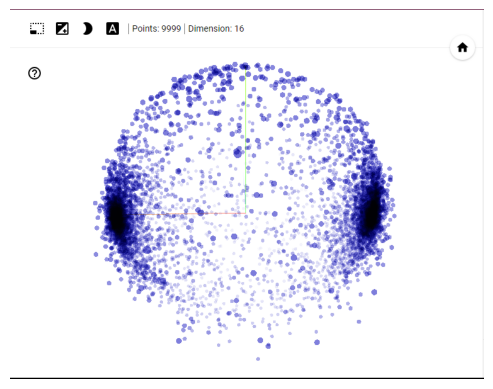

In [45]:
image_path = '/content/imdb reviews projection.png'
img = mpimg.imread(image_path)

plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

# **Sarcasm Dataset** #

The dataset has two features 'headline','article-link' one output variable 'is_sarcastic' either 0(not sarcastic) or 1(sarcastic).

Link to the dataset : https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection

### **Data Collection and Preprocessing** ###

In [47]:
import json

with open("/content/Sarcasm_Headlines_Dataset.json",'r') as f:
  datastore = json.load(f)

sentences = []
labels = []
urls = []

for item in datastore:
  sentences.append(item['headline'])
  labels.append(item['is_sarcastic'])
  urls.append(item['article_link'])

Now our input sentence contains the headlines and the output value 'is_sarcastic' contains labels

In [48]:
len(datastore)

26709

#### **Train-test split** ####

In [49]:
training_size = 20000
training_sentences = sentences[0:training_size]
test_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
test_labels = labels[training_size:]

#### **Tokenization** ####
Similar to the imdb dataset ,The tokenization can be performed

In [50]:
vocab_size = 10000
embedding_dim = 16
max_length = 32
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded_sequences = pad_sequences(training_sequences,padding=padding_type,maxlen=max_length,truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded_sequences = pad_sequences(test_sequences,padding=padding_type,maxlen=max_length,truncating=trunc_type)

In [51]:
#convert to numpy arrays
training_labels_final = np.array(training_labels)
test_labels_final = np.array(test_labels)

### **Model Implementation** ###

#### **Model creation** ####

In [52]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

#### **Model training** ####

In [53]:
# Compile the model
model3.compile(optimizer='adam',  # You can choose other optimizers like 'sgd', 'rmsprop', etc.
              loss='binary_crossentropy',  # Binary cross-entropy for binary classification
              metrics=['accuracy'])  # You can add more metrics if needed

# Train the model
epochs = 30  # Specify the number of training epochs
batch_size = 20  # Specify the batch size
history = model3.fit(training_padded_sequences, training_labels_final, epochs=epochs, batch_size=batch_size, validation_data=(test_padded_sequences,test_labels_final))

Epoch 1/30
1000/1000 [==============================] - 6s 5ms/step - loss: 0.5229 - accuracy: 0.7369 - val_loss: 0.3760 - val_accuracy: 0.8407
Epoch 2/30
1000/1000 [==============================] - 4s 4ms/step - loss: 0.2938 - accuracy: 0.8801 - val_loss: 0.3419 - val_accuracy: 0.8535
Epoch 3/30
1000/1000 [==============================] - 4s 4ms/step - loss: 0.2219 - accuracy: 0.9115 - val_loss: 0.3469 - val_accuracy: 0.8560
Epoch 4/30
1000/1000 [==============================] - 5s 5ms/step - loss: 0.1785 - accuracy: 0.9322 - val_loss: 0.3716 - val_accuracy: 0.8520
Epoch 5/30
1000/1000 [==============================] - 4s 4ms/step - loss: 0.1486 - accuracy: 0.9447 - val_loss: 0.4062 - val_accuracy: 0.8499
Epoch 6/30
1000/1000 [==============================] - 5s 5ms/step - loss: 0.1260 - accuracy: 0.9564 - val_loss: 0.4414 - val_accuracy: 0.8436
Epoch 7/30
1000/1000 [==============================] - 4s 4ms/step - loss: 0.1076 - accuracy: 0.9621 - val_loss: 0.4840 - val_accuracy:

**Training Visualization**

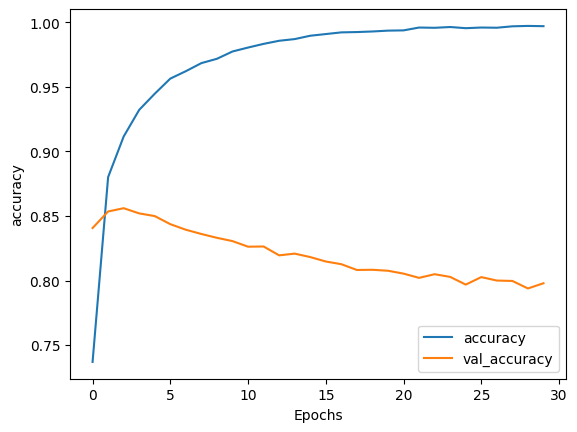

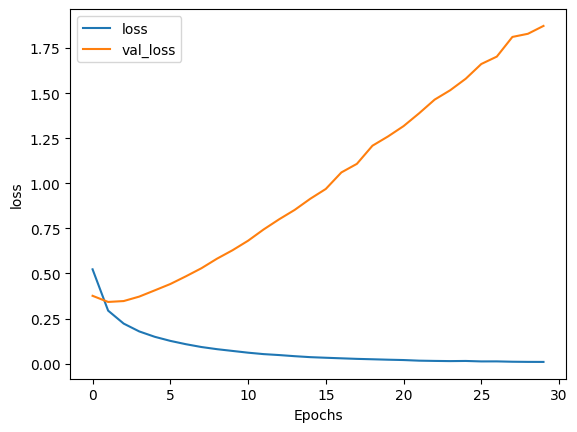

In [55]:
# Plot the accuracy and results
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

**Model summary**

In [ ]:
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 32, 16)            160000    
                                                                 
 global_average_pooling1d_3  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_8 (Dense)             (None, 24)                408       
                                                                 
 dense_9 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160433 (626.69 KB)
Trainable params: 160433 (626.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### **Model Testing** ####
Time for testing...

In [56]:
# Assuming your model is already trained and you have testing data
predictions = model3.predict(test_padded_sequences)

# If you have binary classification, you might want to convert the probabilities to class labels (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)
#binary_predictions

210/210 [==============================] - 0s 1ms/step


In [57]:
# Accuracy
accuracy = accuracy_score(test_labels_final, binary_predictions)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(test_labels_final, binary_predictions)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(test_labels_final, binary_predictions)
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(test_labels_final, binary_predictions)
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.7979
Precision: 0.8123
Recall: 0.6986
F1 Score: 0.7512


Use hyperparameter tuning for best accuracy and other evaluation metrics

### **Embedding vectors** ##

In [58]:
e = model3.layers[0]
weights = e.get_weights()[0]
print(weights.shape) #(vocab_size,embedding_dim)

(10000, 16)


In [59]:
reverse_word_index = tokenizer.index_word
reverse_word_index

{1: '<OOV>',
 2: 'to',
 3: 'of',
 4: 'the',
 5: 'in',
 6: 'for',
 7: 'a',
 8: 'on',
 9: 'and',
 10: 'with',
 11: 'is',
 12: 'new',
 13: 'trump',
 14: 'man',
 15: 'from',
 16: 'at',
 17: 'about',
 18: 'you',
 19: 'by',
 20: 'this',
 21: 'after',
 22: 'be',
 23: 'up',
 24: 'out',
 25: 'that',
 26: 'how',
 27: 'as',
 28: 'it',
 29: 'not',
 30: 'are',
 31: 'your',
 32: 'what',
 33: 'his',
 34: 'all',
 35: 'he',
 36: 'will',
 37: 'who',
 38: 'just',
 39: 'has',
 40: 'more',
 41: 'one',
 42: 'year',
 43: 'into',
 44: 'report',
 45: 'have',
 46: 'why',
 47: 'over',
 48: 'area',
 49: 'u',
 50: 'donald',
 51: 'says',
 52: 'day',
 53: 'can',
 54: 's',
 55: 'first',
 56: 'woman',
 57: 'time',
 58: 'like',
 59: 'get',
 60: 'old',
 61: 'no',
 62: 'her',
 63: "trump's",
 64: 'off',
 65: 'now',
 66: 'an',
 67: 'obama',
 68: 'life',
 69: 'people',
 70: 'women',
 71: 'house',
 72: "'",
 73: 'was',
 74: 'still',
 75: 'white',
 76: 'back',
 77: 'make',
 78: 'than',
 79: 'clinton',
 80: 'down',
 81: 'when

In [60]:
import io

# Write out the embedding vectors and metadata
out_v = io.open('sarcasm_vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('sarcasm_meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [61]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('sarcasm_vecs.tsv')
  files.download('sarcasm_meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Use Tensorflow Embedding Projector to project the vectors. You will see a nice binary classification :)

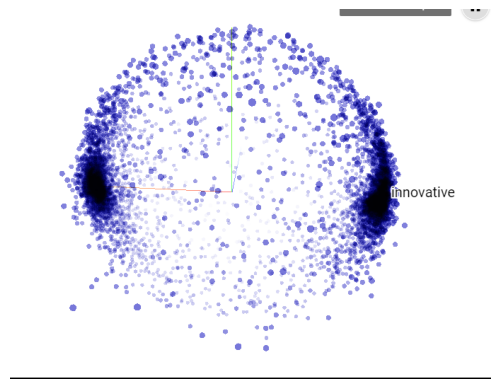

In [62]:
image_path = '/content/sarcasm projection.png'
img = mpimg.imread(image_path)

plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()